In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sp
from scipy import integrate
import sympy

import mpmath

from matplotlib import rc

import utils

mpmath.mp.dps = 1700
# mpmath.mp.prec = 256

In [2]:
labelsize = 14
figsize = (5, 4.5)
ext = "eps"
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
params = {
    'figure.figsize': figsize,
    'font.size' : 12,
    'axes.labelsize': labelsize,
    'legend.fontsize': 12,
}
plt.rcParams.update(params)
workdir = 'figures/conduit_flow'
utils.make_dir_if_missing(workdir)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


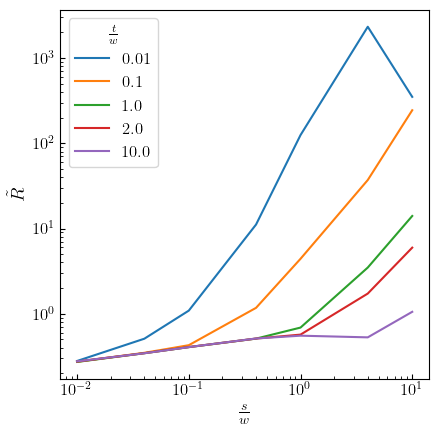

In [3]:
sim_jsons = !find output/conduit_flow -name simulation.json
rows = []
for f in sim_jsons:
    with open(f, "r") as fp:
        data = json.load(fp)
    rows.append(data)
df = pd.DataFrame(rows)
df.head()
df.sort_values(by=['h/w', 's/w'], inplace=True)

fig, ax = plt.subplots()
for h_w in [0.01, 0.1, 1.0, 2.0, 10.0]:
    df_seg = df[np.isclose(df['h/w'], h_w)]
    # h_w = df_seg['h/w'].to_numpy()[0]
    ax.plot(df_seg['s/w'], df_seg['rtilde in'], label=h_w)

ax.legend(title=r'$\frac{t}{w}$');
ax.set_box_aspect(1);
ax.set_xlabel(r'$\frac{s}{w}$');
ax.set_ylabel(r'$\tilde{R}$');
ax.minorticks_on();
ax.tick_params(axis="both", which="both", direction="in")
ax.semilogx();
ax.semilogy();
plt.tight_layout();
plt.savefig(f'{workdir}/rtilde-fea.{ext}', format=ext);

In [4]:
def get_schwarz_christoffel_parameters(s_over_w, h_over_w):
    t = h_over_w
    s = s_over_w
    # imaginary quarter period
    K1 = 1 + s/2

    # real quarter period                                                            
    K2 = t

    # rectangle length = 2(w + s/2)
    Krat = 2*K2/K1

    # elliptic nome
    q = np.exp(-np.pi*Krat)

    # inverse elliptic nome - solve for k
    k = float(mpmath.kfrom(q=q))

    # solve for dimensions
    K = mpmath.ellipk(k**2)

    Cf = K1/2/K
    z1 = -K1/2 + K2*1j;
    z2 =  -K1/2
    z3 =  K1/2 - 1
    z4 = K1/2

    za = mpmath.ellipfun('sn', u=z1/Cf, q=q)
    zb = mpmath.ellipfun('sn', u=z2/Cf, q=q)
    zc = mpmath.ellipfun('sn', u=z3/Cf, q=q)
    zd = mpmath.ellipfun('sn', u=z4/Cf, q=q)
    Dv = np.real((zc - za)/(zc - zb) / ((zd - za)/(zd - zb)))
    m2 = float(np.real((np.sqrt(Dv) - np.sqrt(Dv - 1)) ** 4))

    Krat2 = mpmath.ellipk(1 - m2)/sp.ellipk(m2)

    resist = 4/Krat2

    return resist

In [5]:
def dimensionless_resistance(s_w, h_w):
    Krat = h_w / (s_w + 2.0)
    # print(Krat)
    q = np.exp(-np.pi*Krat)
    # k = mpmath.kfrom(q=q)
    k = mpmath.jtheta(n=2, z=0, q=q)**2/mpmath.jtheta(n=3, z=0, q=q) ** 2

    K = mpmath.ellipk(k**2)

    # correction factor
    Cf = (s_w + 2.0)/K

    K_re = s_w + 2
    K_im = h_w

    z1 = 0.0
    z2 = 1.0
    z3 = 1.0 + s_w
    z4 = K_re

    za = mpmath.ellipfun('sn', u=z1/Cf, q=q)
    zb = mpmath.ellipfun('sn', u=z2/Cf, q=q)
    zc = mpmath.ellipfun('sn', u=z3/Cf, q=q)
    zd = mpmath.ellipfun('sn', u=z4/Cf, q=q)

    l2 = (zd**2 - zc**2)*(za**2 - zb**2)/((za**2 - zc**2)*(zd**2 - zb**2))
    resistance = mpmath.ellipk(1 - l2)/mpmath.ellipk(l2)

    return float(resistance)

In [6]:
def non_dimensional_resistance(s_w, h_w):
    Krat = h_w / (s_w + 2.0)
    # print(Krat)
    q = np.exp(-np.pi*Krat)
    # k = mpmath.kfrom(q=q)
    k = mpmath.jtheta(n=2, z=0, q=q)**2/mpmath.jtheta(n=3, z=0, q=q) ** 2

    K = mpmath.ellipk(k**2)

    # correction factor
    Cf = (s_w + 2.0)/K

    K_re = s_w + 2
    K_im = h_w

    z1 = 0.0
    z2 = 1.0
    z3 = 1.0 + s_w
    z4 = K_re

    za = abs(float(mpmath.ellipfun('sn', u=z1/Cf, q=q)))
    zb = float(mpmath.ellipfun('sn', u=z2/Cf, q=q))
    zc = float(mpmath.ellipfun('sn', u=z3/Cf, q=q))
    zd = float(mpmath.ellipfun('sn', u=z4/Cf, q=q))
    print(f"t1: {za}, t2: {zb}, t3: {zc}, t4: {zd}")

    x = sympy.Symbol('x')
    Xi_re = sympy.im(sympy.Integral(1/((x-za)*(x-zb)*(x-zc)*(x-zd))**0.5, (x, za, zb)).evalf())
    Xi_im = sympy.re(sympy.Integral(1/((x-za)*(x-zb)*(x-zc)*(x-zd))**0.5, (x, zb, zc)).evalf())

    return abs(Xi_im/Xi_re)

In [7]:
# %timeit dimensionless_resistance(s_w=0.01, h_w=0.01)

In [8]:
# %timeit non_dimensional_resistance(s_w=0.01, h_w=1)

In [9]:
# x = sympy.Symbol('x')
# t1 = 0
# t2 = 0.9236752136382036
# t3 = 0.926147520961329
# t4 = 1.0
# integ = sympy.Integral(1/((x-0)*(x-t2)*(x-t3)*(x-t4))**0.5, (x, t1, t2))
# integ1 = sympy.Integral(1/((x-0)*(x-t2)*(x-t3)*(x-t4))**0.5, (x, t3, t4))
# integ2 = sympy.Integral(1/((x-0)*(x-t2)*(x-t3)*(x-t4))**0.5, (x, t2, t3))..
# integ.evalf(), integ1.evalf(), integ2.evalf()

In [10]:
# %timeit sympy.Integral(1/((x-0)*(x-t2)*(x-t3)*(x-t4))**0.5, (x, t2, t3)).evalf()

In [11]:
# t1 = 0
# t2 = 0.9999999999999546
# t3 = 0.9999999999999668
# t4 = 1.0
# f = lambda t: 1/((t-0)*(t-t2)*(t-t3)*(t-t4))**0.5
# %timeit integrate.quad(f, t2, t3)

In [12]:
h_over_ws = [0.01, 0.1, 1.0, 2.0, 10]
s_over_ws = np.arange(0.01, 10.01, step=0.01)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


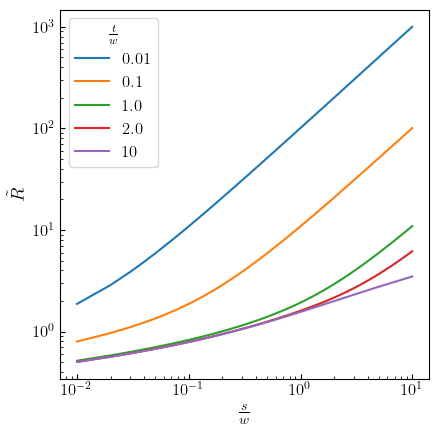

In [13]:
fig, ax = plt.subplots()
for t_over_w in h_over_ws:
    rtildes = []
    for s_over_w in s_over_ws:
        try:
            # rtilde = get_schwarz_christoffel_parameters(s_over_w=s_over_w, h_over_w=t_over_w)
            rtilde = dimensionless_resistance(s_w=s_over_w, h_w=t_over_w)
        except Exception as e:
            rtilde = np.nan
        rtildes.append(rtilde)
    ax.plot(s_over_ws, rtildes, label=f'{t_over_w}')
ax.legend(title=r'$\frac{t}{w}$');
ax.set_box_aspect(1);
ax.set_xlabel(r'$\frac{s}{w}$');
ax.set_ylabel(r'$\tilde{R}$');
ax.minorticks_on();
ax.tick_params(axis="both", which="both", direction="in")
ax.semilogx();
ax.semilogy();
plt.tight_layout();
plt.savefig(f'{workdir}/rtilde-new.{ext}', format=ext);